# Multi-Class Property Tier Classification Analysis

## Objective
Classify properties into performance tiers (Premium/Standard/Budget) and identify which features drive tier classification to provide actionable business insights.

## Business Context
Understanding property tier classification is crucial for:
- Strategic pricing decisions
- Investment prioritization
- Market positioning
- Resource allocation
- Competitive analysis


## 1. Data Loading and Initial Exploration


In [13]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    f1_score, precision_score, recall_score, roc_auc_score,
    roc_curve, precision_recall_curve
)
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")


Libraries imported successfully!


In [14]:
# Load the dataset
df = pd.read_excel('combined.xlsx')

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nData types:\n{df.dtypes.value_counts()}")


Dataset shape: (1558, 63)

Columns: ['property_id', 'city', 'state', 'zipcode', 'latitude', 'longitude', 'urban_classification', 'bedrooms', 'bathrooms', 'total_sqft', 'parking_spaces', 'building_type', 'building_age', 'last_renovation', 'condition_score', 'coworking_space', 'gym', 'pool', 'laundry', 'pet_friendly', 'smart_home_level', 'ev_charging', 'outdoor_space', 'bike_storage', 'furnished', 'utilities_included', 'common_area_sqft', 'walk_score', 'transit_score', 'bike_score', 'distance_university', 'nearest_university', 'distance_tech_hub', 'nearest_tech_hub', 'distance_downtown', 'distance_transit_station', 'crime_index', 'restaurant_count', 'park_count', 'school_quality_score', 'noise_level', 'median_age_zipcode', 'median_income_zipcode', 'pct_bachelors_degree', 'pct_graduate_degree', 'pct_renters', 'pct_remote_workers', 'population_density', 'competitor_count_1mi', 'market_vacancy_rate', 'rent_growth_rate_annual', 'market_maturity_years', 'avg_market_occupancy', 'property_tax_r

Property Tier Distribution:
property_tier
Standard    816
Premium     678
Budget       64
Name: count, dtype: int64

Percentage distribution:
property_tier
Standard    52.374840
Premium     43.517330
Budget       4.107831
Name: proportion, dtype: float64


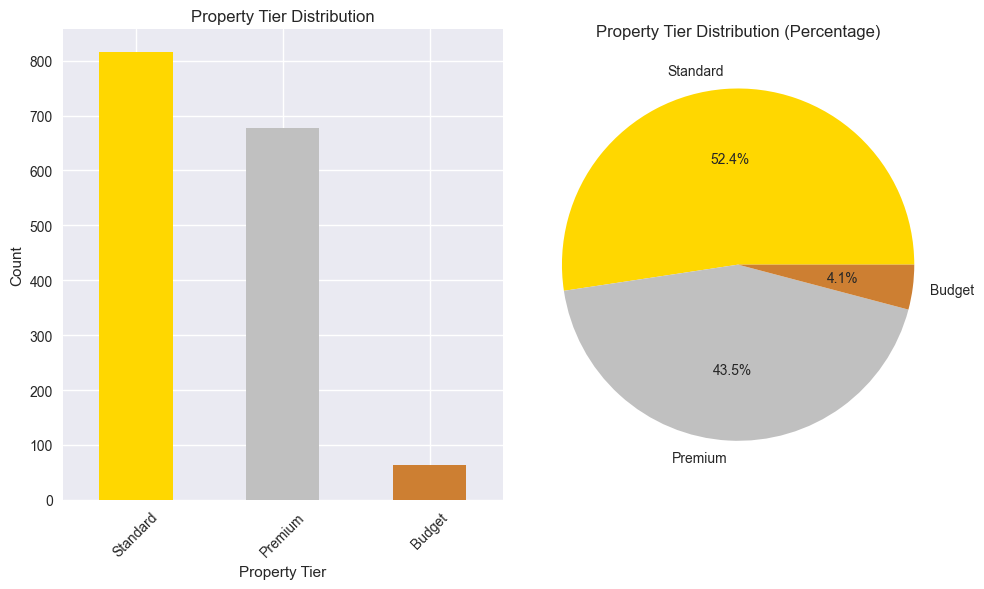

In [15]:
# Check for property_tier column and its distribution
if 'property_tier' in df.columns:
    print("Property Tier Distribution:")
    tier_counts = df['property_tier'].value_counts()
    print(tier_counts)
    print(f"\nPercentage distribution:")
    print(df['property_tier'].value_counts(normalize=True) * 100)
    
    # Visualize tier distribution
    plt.figure(figsize=(10, 6))
    
    plt.subplot(1, 2, 1)
    tier_counts.plot(kind='bar', color=['gold', 'silver', '#CD7F32'])
    plt.title('Property Tier Distribution')
    plt.xlabel('Property Tier')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    
    plt.subplot(1, 2, 2)
    plt.pie(tier_counts.values, labels=tier_counts.index, autopct='%1.1f%%', 
            colors=['gold', 'silver', '#CD7F32'])
    plt.title('Property Tier Distribution (Percentage)')
    
    plt.tight_layout()
    plt.show()
else:
    print("Property tier column not found. Let's examine the data structure:")
    print(df.head())


## 2. Exploratory Data Analysis (EDA)


In [16]:
# Basic data information
print("=== DATASET OVERVIEW ===")
print(f"Total properties: {len(df)}")
print(f"Total features: {len(df.columns)}")
print(f"Missing values: {df.isnull().sum().sum()}")
print(f"\nMissing values by column:")
missing_data = df.isnull().sum()
missing_data = missing_data[missing_data > 0].sort_values(ascending=False)
if len(missing_data) > 0:
    print(missing_data)
else:
    print("No missing values found!")


=== DATASET OVERVIEW ===
Total properties: 1558
Total features: 63
Missing values: 4101

Missing values by column:
nearest_tech_hub      1558
nearest_university    1558
coworking_space        607
smart_home_level       378
dtype: int64


=== KEY FEATURES BY PROPERTY TIER ===
              total_sqft                  bedrooms              bathrooms  \
                    mean   median     std     mean median   std      mean   
property_tier                                                               
Budget           1875.46  1917.35  379.39     4.09    4.0  1.00      2.12   
Premium          1872.01  1836.05  410.86     3.94    4.0  1.08      2.00   
Standard         1902.78  1889.15  399.19     4.17    4.0  1.07      2.13   

                           condition_score  ...       walk_score               \
              median   std            mean  ...   std       mean median   std   
property_tier                               ...                                 
Budget           2.0  0.63           78.69  ...  8.99      59.47  57.50  6.94   
Premium          2.0  0.65           83.83  ...  7.60      63.16  63.45  7.39   
Standard         2.0  0.65           80.99  ...  9.13      61.58  61.00  7.11   

            

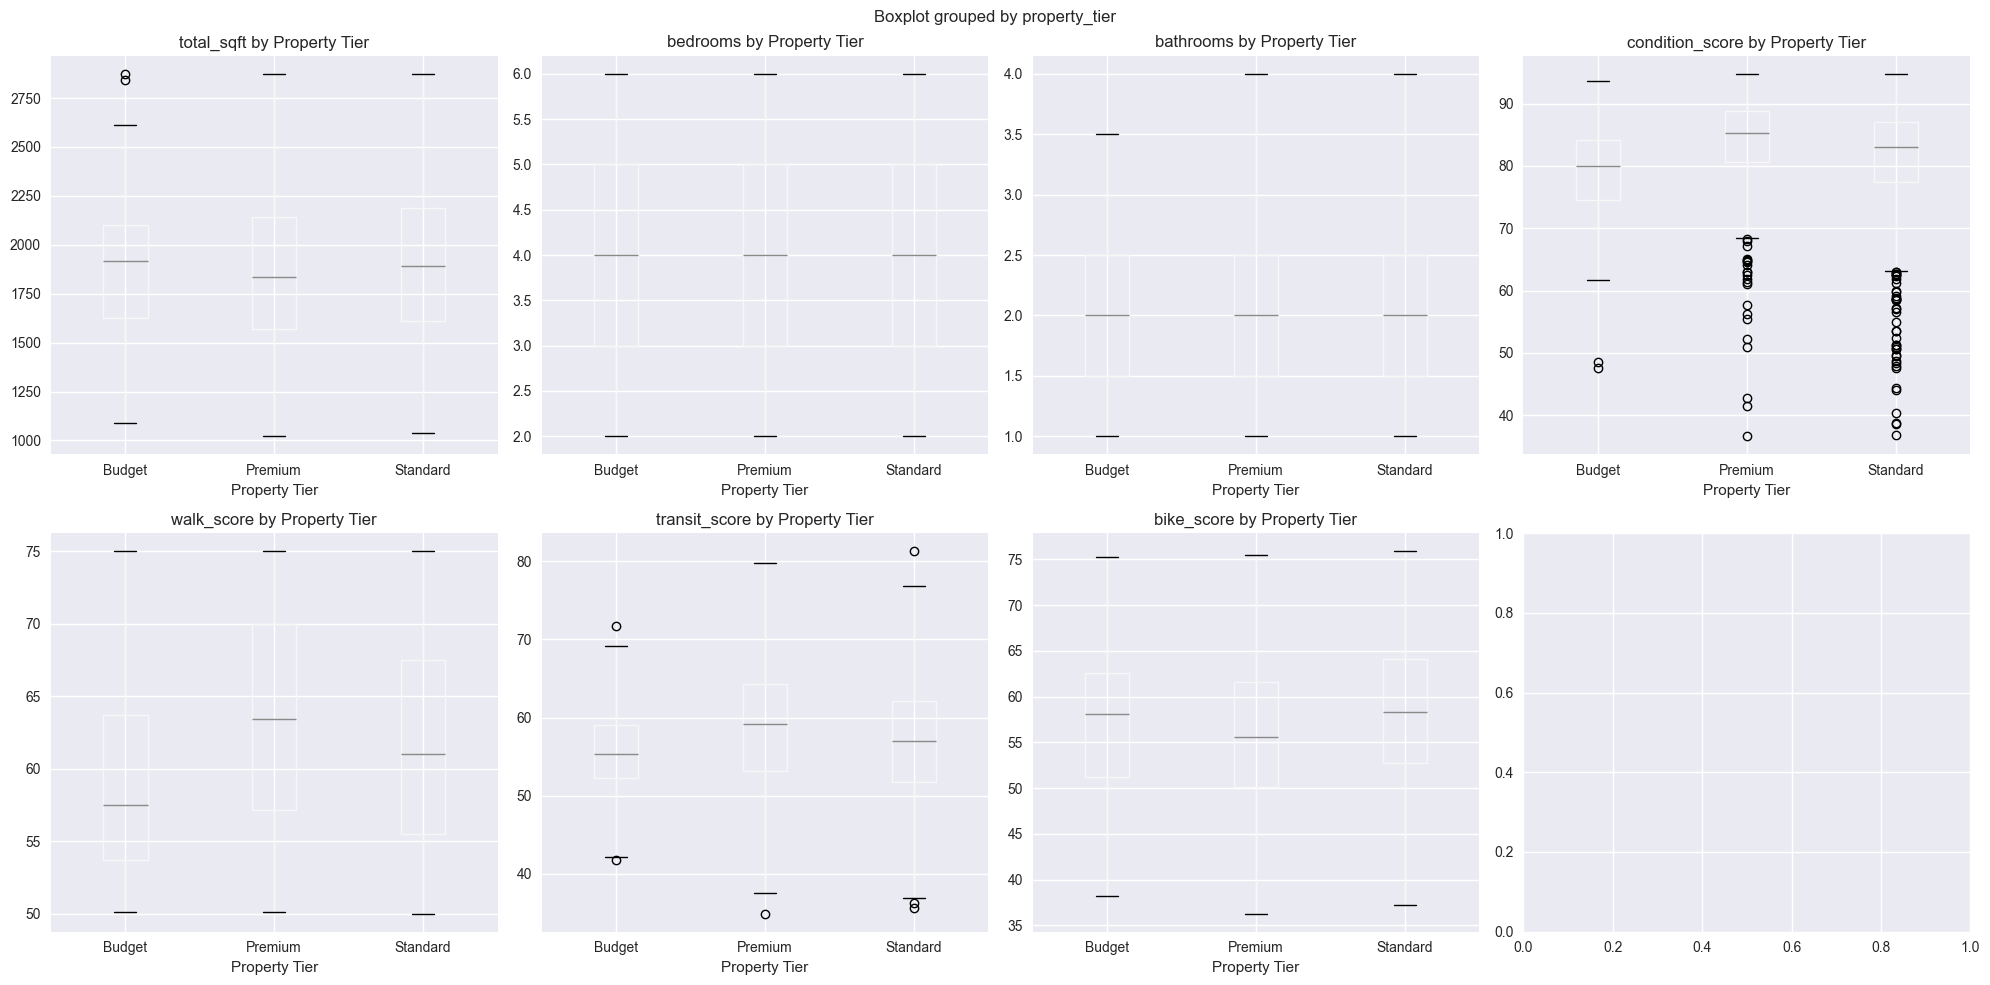

In [17]:
# Analyze key numerical features by property tier
if 'property_tier' in df.columns:
    # Select key numerical features for analysis
    numerical_features = ['monthly_rent', 'total_sqft', 'bedrooms', 'bathrooms', 
                         'condition_score', 'walk_score', 'transit_score', 'bike_score']
    
    # Filter to existing columns
    numerical_features = [col for col in numerical_features if col in df.columns]
    
    if numerical_features:
        print("=== KEY FEATURES BY PROPERTY TIER ===")
        tier_summary = df.groupby('property_tier')[numerical_features].agg(['mean', 'median', 'std'])
        print(tier_summary.round(2))
        
        # Visualize distributions
        fig, axes = plt.subplots(2, 4, figsize=(20, 10))
        axes = axes.ravel()
        
        for i, feature in enumerate(numerical_features[:8]):
            if i < len(axes):
                df.boxplot(column=feature, by='property_tier', ax=axes[i])
                axes[i].set_title(f'{feature} by Property Tier')
                axes[i].set_xlabel('Property Tier')
        
        plt.tight_layout()
        plt.show()
    else:
        print("No standard numerical features found. Let's examine available columns:")
        print(df.select_dtypes(include=[np.number]).columns.tolist())


=== CATEGORICAL FEATURES BY PROPERTY TIER ===


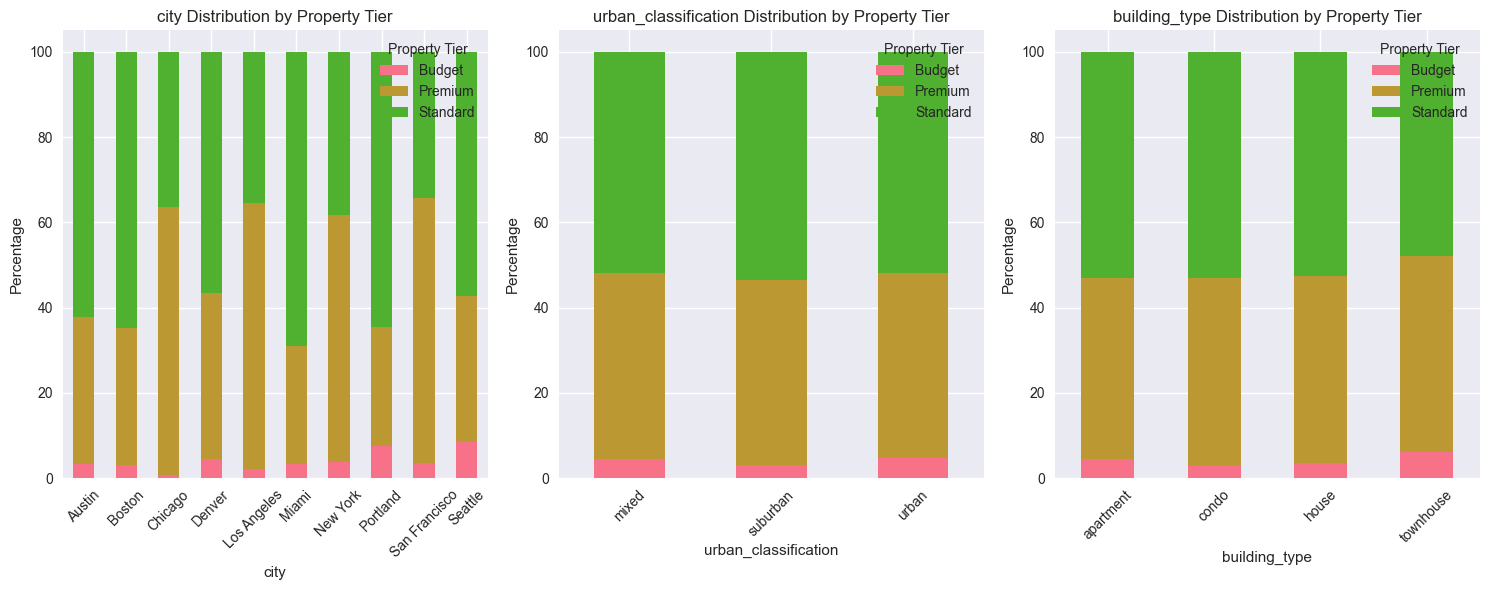


CITY CROSS-TABULATION:
property_tier  Budget  Premium  Standard   All
city                                          
Austin              5       52        94   151
Boston              5       51       103   159
Chicago             1       85        49   135
Denver              6       53        77   136
Los Angeles         3       92        52   147
Miami               6       49       123   178
New York            6       92        61   159
Portland           13       49       113   175
San Francisco       6      103        57   166
Seattle            13       52        87   152
All                64      678       816  1558

URBAN_CLASSIFICATION CROSS-TABULATION:
property_tier         Budget  Premium  Standard   All
urban_classification                                 
mixed                     24      233       276   533
suburban                  15      216       266   497
urban                     25      229       274   528
All                       64      678       816  1558



In [18]:
# Analyze categorical features by property tier
if 'property_tier' in df.columns:
    categorical_features = ['city', 'urban_classification', 'building_type']
    categorical_features = [col for col in categorical_features if col in df.columns]
    
    if categorical_features:
        print("=== CATEGORICAL FEATURES BY PROPERTY TIER ===")
        
        fig, axes = plt.subplots(1, len(categorical_features), figsize=(5*len(categorical_features), 6))
        if len(categorical_features) == 1:
            axes = [axes]
        
        for i, feature in enumerate(categorical_features):
            # Create cross-tabulation
            crosstab = pd.crosstab(df[feature], df['property_tier'], normalize='index') * 100
            
            # Plot
            crosstab.plot(kind='bar', ax=axes[i], stacked=True)
            axes[i].set_title(f'{feature} Distribution by Property Tier')
            axes[i].set_xlabel(feature)
            axes[i].set_ylabel('Percentage')
            axes[i].legend(title='Property Tier')
            axes[i].tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.show()
        
        # Print detailed cross-tabulation
        for feature in categorical_features:
            print(f"\n{feature.upper()} CROSS-TABULATION:")
            print(pd.crosstab(df[feature], df['property_tier'], margins=True))


## 3. Feature Engineering and Data Preprocessing


In [19]:
# Create a copy for preprocessing
df_processed = df.copy()

print("=== FEATURE ENGINEERING ===")

# Handle missing values
print("Handling missing values...")
missing_before = df_processed.isnull().sum().sum()

# Fill missing values for categorical variables
categorical_cols = df_processed.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if col != 'property_tier':  # Don't fill the target variable
        df_processed[col] = df_processed[col].fillna('Unknown')

# Fill missing values for numerical variables
numerical_cols = df_processed.select_dtypes(include=[np.number]).columns
for col in numerical_cols:
    if col != 'property_tier':  # Don't fill the target variable
        df_processed[col] = df_processed[col].fillna(df_processed[col].median())

missing_after = df_processed.isnull().sum().sum()
print(f"Missing values before: {missing_before}")
print(f"Missing values after: {missing_after}")


=== FEATURE ENGINEERING ===
Handling missing values...
Missing values before: 4101
Missing values after: 3116


In [20]:
# Create new features
print("Creating new features...")

# Amenity score (if boolean amenity columns exist)
amenity_cols = ['gym', 'pool', 'pet_friendly', 'ev_charging', 'outdoor_space', 
                'bike_storage', 'furnished', 'utilities_included']
amenity_cols = [col for col in amenity_cols if col in df_processed.columns]

if amenity_cols:
    # Convert boolean columns to int if they exist
    for col in amenity_cols:
        if df_processed[col].dtype == 'bool':
            df_processed[col] = df_processed[col].astype(int)
    
    df_processed['amenity_score'] = df_processed[amenity_cols].sum(axis=1)
    print(f"Created amenity_score from {len(amenity_cols)} amenity features")

# Location score (combine walk, transit, bike scores)
location_cols = ['walk_score', 'transit_score', 'bike_score']
location_cols = [col for col in location_cols if col in df_processed.columns]

if len(location_cols) >= 2:
    df_processed['location_score'] = df_processed[location_cols].mean(axis=1)
    print(f"Created location_score from {len(location_cols)} location features")

# Property size per bedroom
if 'total_sqft' in df_processed.columns and 'bedrooms' in df_processed.columns:
    df_processed['sqft_per_bedroom'] = df_processed['total_sqft'] / df_processed['bedrooms'].replace(0, 1)
    print("Created sqft_per_bedroom feature")

# Age-related features
if 'building_age' in df_processed.columns and 'last_renovation' in df_processed.columns:
    df_processed['age_since_renovation'] = df_processed['building_age'] - df_processed['last_renovation']
    print("Created age_since_renovation feature")

print(f"\nNew dataset shape: {df_processed.shape}")


Creating new features...
Created amenity_score from 8 amenity features
Created location_score from 3 location features
Created sqft_per_bedroom feature
Created age_since_renovation feature

New dataset shape: (1558, 67)


In [21]:
# Prepare features and target
if 'property_tier' in df_processed.columns:
    # Separate target variable
    y = df_processed['property_tier']
    
    # Remove target and ID columns from features
    columns_to_drop = ['property_tier', 'property_id']
    X = df_processed.drop(columns=[col for col in columns_to_drop if col in df_processed.columns])
    
    # One-hot encode categorical variables
    categorical_columns = X.select_dtypes(include=['object']).columns
    if len(categorical_columns) > 0:
        X_encoded = pd.get_dummies(X, columns=categorical_columns, drop_first=True)
        print(f"One-hot encoded {len(categorical_columns)} categorical columns")
    else:
        X_encoded = X
    
    print(f"Final feature matrix shape: {X_encoded.shape}")
    print(f"Target variable distribution:")
    print(y.value_counts())
    
    # Check for class imbalance
    class_balance = y.value_counts(normalize=True)
    print(f"\nClass balance:")
    for tier, proportion in class_balance.items():
        print(f"{tier}: {proportion:.2%}")
    
    # Check if classes are balanced (within 10% of each other)
    max_prop = class_balance.max()
    min_prop = class_balance.min()
    is_balanced = (max_prop - min_prop) < 0.1
    print(f"\nClasses are {'balanced' if is_balanced else 'imbalanced'} (max-min difference: {max_prop-min_prop:.2%})")
    
else:
    print("Property tier column not found. Cannot proceed with classification.")
    print("Available columns:", list(df_processed.columns))


One-hot encoded 7 categorical columns
Final feature matrix shape: (1558, 85)
Target variable distribution:
property_tier
Standard    816
Premium     678
Budget       64
Name: count, dtype: int64

Class balance:
Standard: 52.37%
Premium: 43.52%
Budget: 4.11%

Classes are imbalanced (max-min difference: 48.27%)


## 4. Model Training and Evaluation


In [22]:
# Train-test split
if 'property_tier' in df_processed.columns:
    X_train, X_test, y_train, y_test = train_test_split(
        X_encoded, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    print(f"Training set size: {X_train.shape[0]}")
    print(f"Test set size: {X_test.shape[0]}")
    print(f"Number of features: {X_train.shape[1]}")
    
    # Check for any infinite or NaN values
    X_train_scaled = np.nan_to_num(X_train_scaled)
    X_test_scaled = np.nan_to_num(X_test_scaled)
    
    # Also clean the original data to prevent NaN issues
    X_train = X_train.fillna(0)
    X_test = X_test.fillna(0)
    
    print("Data preprocessing completed successfully!")
    print(f"NaN values in X_train: {X_train.isnull().sum().sum()}")
    print(f"NaN values in X_test: {X_test.isnull().sum().sum()}")
    print(f"NaN values in X_train_scaled: {np.isnan(X_train_scaled).sum()}")
    print(f"NaN values in X_test_scaled: {np.isnan(X_test_scaled).sum()}")
else:
    print("Cannot proceed without property_tier column")


Training set size: 1246
Test set size: 312
Number of features: 85
Data preprocessing completed successfully!
NaN values in X_train: 0
NaN values in X_test: 0
NaN values in X_train_scaled: 0
NaN values in X_test_scaled: 0


In [23]:
# Define models and hyperparameters
if 'property_tier' in df_processed.columns:
    models = {
        'Logistic Regression': {
            'model': LogisticRegression(random_state=42, max_iter=1000),
            'params': {
                'C': [0.01, 0.1, 1, 10, 100],
                'solver': ['lbfgs', 'liblinear'],
                'penalty': ['l2']
            }
        },
        'K-Nearest Neighbors': {
            'model': KNeighborsClassifier(),
            'params': {
                'n_neighbors': [3, 5, 7, 9, 11, 15],
                'weights': ['uniform', 'distance'],
                'p': [1, 2]
            }
        },
        'Decision Tree': {
            'model': DecisionTreeClassifier(random_state=42),
            'params': {
                'max_depth': [3, 5, 7, 10, None],
                'min_samples_split': [2, 5, 10, 20],
                'min_samples_leaf': [1, 3, 5, 10]
            }
        },
        'Random Forest': {
            'model': RandomForestClassifier(random_state=42),
            'params': {
                'n_estimators': [50, 100, 200],
                'max_depth': [3, 5, 7, None],
                'min_samples_split': [2, 5, 10]
            }
        }
    }
    
    print("Models and hyperparameters defined successfully!")
    print(f"Will train {len(models)} different models")
else:
    print("Cannot define models without property_tier column")


Models and hyperparameters defined successfully!
Will train 4 different models


In [24]:
# Train and evaluate models
if 'property_tier' in df_processed.columns:
    results = {}
    best_models = {}
    
    print("=== MODEL TRAINING AND EVALUATION ===")
    
    for name, config in models.items():
        print(f"\nTraining {name}...")
        
        # Grid search for hyperparameter tuning
        grid_search = GridSearchCV(
            config['model'], 
            config['params'], 
            cv=5, 
            scoring='f1_macro',  # Use macro F1 for multi-class
            n_jobs=-1,
            verbose=0
        )
        
        # Use scaled data for Logistic Regression and KNN, original for tree-based models
        if name in ['Logistic Regression', 'K-Nearest Neighbors']:
            grid_search.fit(X_train_scaled, y_train)
            y_pred = grid_search.predict(X_test_scaled)
            y_pred_proba = grid_search.predict_proba(X_test_scaled)
        else:
            grid_search.fit(X_train, y_train)
            y_pred = grid_search.predict(X_test)
            y_pred_proba = grid_search.predict_proba(X_test)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        f1_macro = f1_score(y_test, y_pred, average='macro')
        f1_weighted = f1_score(y_test, y_pred, average='weighted')
        
        results[name] = {
            'accuracy': accuracy,
            'f1_macro': f1_macro,
            'f1_weighted': f1_weighted,
            'best_params': grid_search.best_params_
        }
        
        best_models[name] = grid_search.best_estimator_
        
        print(f"Best parameters: {grid_search.best_params_}")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"F1 (macro): {f1_macro:.4f}")
        print(f"F1 (weighted): {f1_weighted:.4f}")
    
    # Create results DataFrame
    results_df = pd.DataFrame(results).T
    results_df = results_df.drop('best_params', axis=1)  # Remove params column for cleaner display
    
    print("\n=== MODEL COMPARISON ===")
    print(results_df.round(4))
    
    # Find best model
    best_model_name = results_df['f1_macro'].idxmax()
    print(f"\nBest model: {best_model_name} (F1-macro: {results_df.loc[best_model_name, 'f1_macro']:.4f})")
    
else:
    print("Cannot train models without property_tier column")


=== MODEL TRAINING AND EVALUATION ===

Training Logistic Regression...
Best parameters: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
Accuracy: 0.9679
F1 (macro): 0.8928
F1 (weighted): 0.9675

Training K-Nearest Neighbors...
Best parameters: {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
Accuracy: 0.7019
F1 (macro): 0.5160
F1 (weighted): 0.6898

Training Decision Tree...
Best parameters: {'max_depth': 10, 'min_samples_leaf': 3, 'min_samples_split': 2}
Accuracy: 0.9135
F1 (macro): 0.8260
F1 (weighted): 0.9147

Training Random Forest...
Best parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}
Accuracy: 0.9071
F1 (macro): 0.7334
F1 (weighted): 0.8991

=== MODEL COMPARISON ===
                     accuracy  f1_macro f1_weighted
Logistic Regression  0.967949  0.892779    0.967518
K-Nearest Neighbors  0.701923  0.516006    0.689797
Decision Tree        0.913462  0.826026    0.914707
Random Forest        0.907051  0.733404    0.899148

Best model: Logistic Regressi

## 5. Detailed Model Analysis


=== DETAILED ANALYSIS: LOGISTIC REGRESSION ===

Classification Report:
              precision    recall  f1-score   support

      Budget       0.75      0.69      0.72        13
     Premium       0.99      0.99      0.99       136
    Standard       0.97      0.97      0.97       163

    accuracy                           0.97       312
   macro avg       0.90      0.88      0.89       312
weighted avg       0.97      0.97      0.97       312



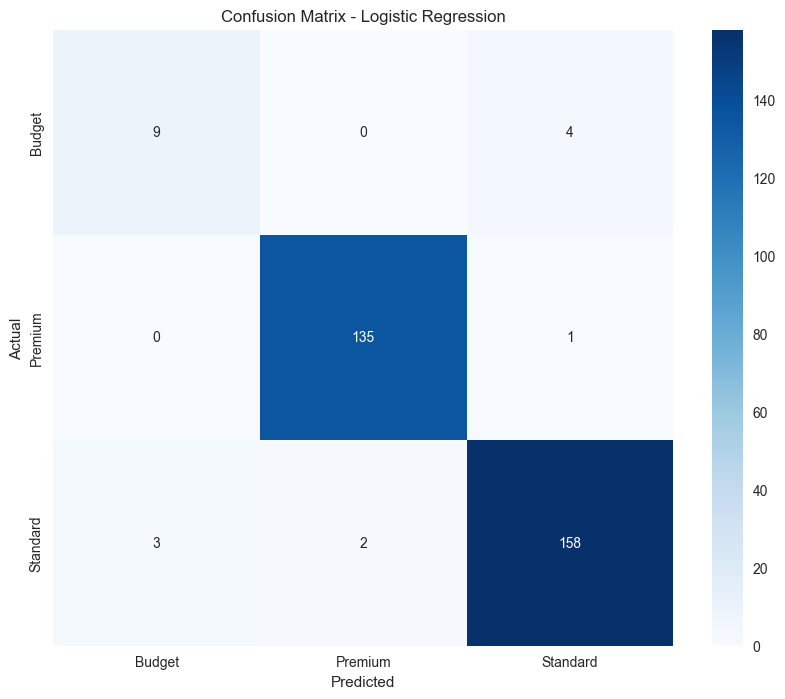


Per-class Accuracy:
Budget: 0.6923
Premium: 0.9926
Standard: 0.9693


In [25]:
# Detailed analysis of best model
if 'property_tier' in df_processed.columns and 'best_model_name' in locals():
    best_model = best_models[best_model_name]
    
    # Get predictions
    if best_model_name == 'Logistic Regression':
        y_pred_best = best_model.predict(X_test_scaled)
        y_pred_proba_best = best_model.predict_proba(X_test_scaled)
    else:
        y_pred_best = best_model.predict(X_test)
        y_pred_proba_best = best_model.predict_proba(X_test)
    
    print(f"=== DETAILED ANALYSIS: {best_model_name.upper()} ===")
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_best))
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred_best)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=sorted(y.unique()), 
                yticklabels=sorted(y.unique()))
    plt.title(f'Confusion Matrix - {best_model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # Per-class accuracy
    class_accuracy = cm.diagonal() / cm.sum(axis=1)
    print("\nPer-class Accuracy:")
    for i, tier in enumerate(sorted(y.unique())):
        print(f"{tier}: {class_accuracy[i]:.4f}")
    
else:
    print("Cannot perform detailed analysis without trained models")


=== FEATURE IMPORTANCE ANALYSIS ===

Logistic Regression Coefficients (Top 10 per class):

Budget:
revenue_per_sqft               6.462396
monthly_revenue_per_bedroom    6.217914
annual_revenue                 5.322290
total_monthly_revenue          5.322288
sqft_per_bedroom               2.740743
city_San Francisco             2.655349
bedrooms                       2.573888
city_Los Angeles               2.332628
occupancy_rate                 2.267230
state_TX                       2.177895
Name: Budget, dtype: float64

Premium:
monthly_revenue_per_bedroom    8.330008
revenue_per_sqft               7.629883
annual_revenue                 5.427793
total_monthly_revenue          5.427791
sqft_per_bedroom               3.884466
city_San Francisco             2.922448
bedrooms                       2.835545
city_Los Angeles               2.786756
occupancy_rate                 2.666294
state_TX                       2.421687
Name: Premium, dtype: float64

Standard:
monthly_revenue_per_b

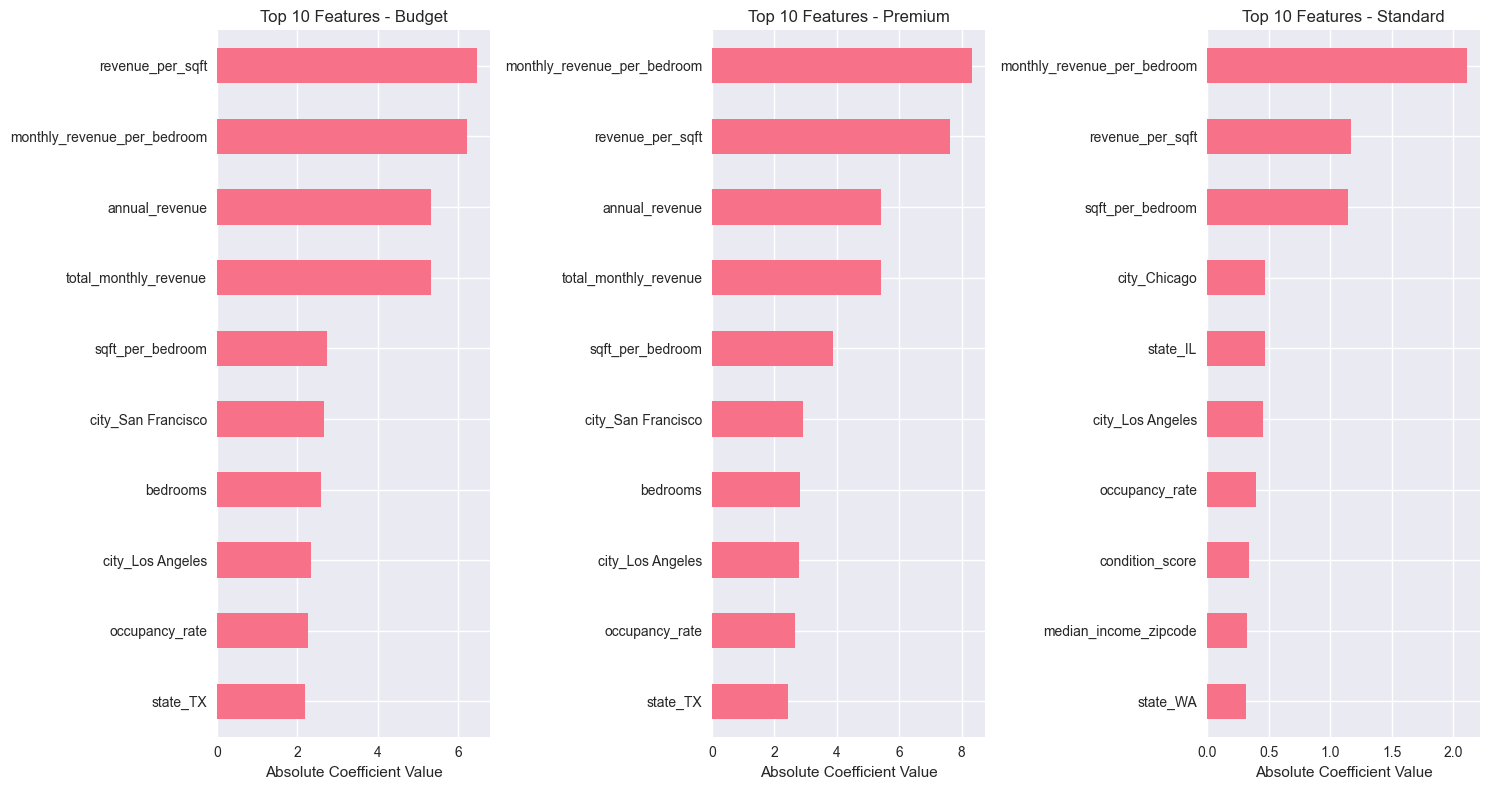

In [26]:
# Feature importance analysis
if 'property_tier' in df_processed.columns and 'best_model_name' in locals():
    print(f"=== FEATURE IMPORTANCE ANALYSIS ===")
    
    # Get feature importance based on model type
    if hasattr(best_model, 'feature_importances_'):
        # Tree-based models
        importances = pd.Series(best_model.feature_importances_, index=X_encoded.columns)
        importances = importances.sort_values(ascending=False)
        
        print("\nTop 15 Most Important Features:")
        print(importances.head(15))
        
        # Plot feature importance
        plt.figure(figsize=(12, 8))
        importances.head(15).plot(kind='barh')
        plt.title(f'Top 15 Feature Importances - {best_model_name}')
        plt.xlabel('Importance')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
        
    elif hasattr(best_model, 'coef_'):
        # Logistic regression
        # For multi-class, we get coefficients for each class
        classes = best_model.classes_
        coef_df = pd.DataFrame(best_model.coef_, 
                              index=classes, 
                              columns=X_encoded.columns)
        
        print("\nLogistic Regression Coefficients (Top 10 per class):")
        for class_name in classes:
            print(f"\n{class_name}:")
            class_coef = coef_df.loc[class_name].abs().sort_values(ascending=False)
            print(class_coef.head(10))
        
        # Plot coefficients for each class
        fig, axes = plt.subplots(1, len(classes), figsize=(5*len(classes), 8))
        if len(classes) == 1:
            axes = [axes]
        
        for i, class_name in enumerate(classes):
            class_coef = coef_df.loc[class_name].abs().sort_values(ascending=False).head(10)
            class_coef.plot(kind='barh', ax=axes[i])
            axes[i].set_title(f'Top 10 Features - {class_name}')
            axes[i].set_xlabel('Absolute Coefficient Value')
            axes[i].invert_yaxis()
        
        plt.tight_layout()
        plt.show()
    
    else:
        print("Feature importance not available for this model type")
        
else:
    print("Cannot analyze feature importance without trained models")


## 6. Business Insights and Strategic Analysis


In [27]:
# Business insights analysis
if 'property_tier' in df_processed.columns:
    print("=== BUSINESS INSIGHTS ANALYSIS ===")
    
    # 1. Tier distribution by key factors
    print("\n1. PROPERTY TIER CHARACTERISTICS:")
    
    # Analyze by key numerical features
    key_features = ['monthly_rent', 'total_sqft', 'bedrooms', 'bathrooms', 'condition_score']
    key_features = [col for col in key_features if col in df_processed.columns]
    
    if key_features:
        tier_stats = df_processed.groupby('property_tier')[key_features].agg(['mean', 'median'])
        print("\nAverage values by tier:")
        print(tier_stats.round(2))
        
        # Calculate tier premiums
        if 'monthly_rent' in key_features:
            rent_by_tier = df_processed.groupby('property_tier')['monthly_rent'].mean()
            print("\nRent Premium Analysis:")
            for tier in sorted(rent_by_tier.index):
                if tier != rent_by_tier.index[0]:  # Skip first tier
                    base_rent = rent_by_tier.iloc[0]
                    premium = ((rent_by_tier[tier] - base_rent) / base_rent) * 100
                    print(f"{tier} vs {rent_by_tier.index[0]}: {premium:.1f}% premium")
    
    # 2. Location analysis
    print("\n2. LOCATION IMPACT ON TIER CLASSIFICATION:")
    
    location_features = ['city', 'urban_classification']
    location_features = [col for col in location_features if col in df_processed.columns]
    
    for feature in location_features:
        if feature in df_processed.columns:
            print(f"\n{feature.upper()}:")
            location_tier_dist = pd.crosstab(df_processed[feature], df_processed['property_tier'], normalize='index') * 100
            print(location_tier_dist.round(1))
    
    # 3. Amenity analysis
    if 'amenity_score' in df_processed.columns:
        print("\n3. AMENITY IMPACT:")
        amenity_by_tier = df_processed.groupby('property_tier')['amenity_score'].agg(['mean', 'std'])
        print(amenity_by_tier.round(2))
        
        # Statistical test for amenity differences
        from scipy import stats
        tiers = df_processed['property_tier'].unique()
        if len(tiers) > 1:
            tier1_data = df_processed[df_processed['property_tier'] == tiers[0]]['amenity_score']
            tier2_data = df_processed[df_processed['property_tier'] == tiers[1]]['amenity_score']
            t_stat, p_value = stats.ttest_ind(tier1_data, tier2_data)
            print(f"\nT-test between {tiers[0]} and {tiers[1]} amenity scores:")
            print(f"T-statistic: {t_stat:.4f}, P-value: {p_value:.4f}")
    
else:
    print("Cannot perform business insights analysis without property_tier column")


=== BUSINESS INSIGHTS ANALYSIS ===

1. PROPERTY TIER CHARACTERISTICS:

Average values by tier:
              total_sqft          bedrooms        bathrooms         \
                    mean   median     mean median      mean median   
property_tier                                                        
Budget           1875.46  1917.35     4.09    4.0      2.12    2.0   
Premium          1872.01  1836.05     3.94    4.0      2.00    2.0   
Standard         1902.78  1889.15     4.17    4.0      2.13    2.0   

              condition_score         
                         mean median  
property_tier                         
Budget                  78.69  80.05  
Premium                 83.83  85.30  
Standard                80.99  83.00  

2. LOCATION IMPACT ON TIER CLASSIFICATION:

CITY:
property_tier  Budget  Premium  Standard
city                                    
Austin            3.3     34.4      62.3
Boston            3.1     32.1      64.8
Chicago           0.7     63.0     

In [28]:
# Market positioning analysis
if 'property_tier' in df_processed.columns:
    print("\n=== MARKET POSITIONING ANALYSIS ===")
    
    # Create market positioning matrix
    if 'monthly_rent' in df_processed.columns and 'condition_score' in df_processed.columns:
        plt.figure(figsize=(12, 8))
        
        # Create scatter plot
        for tier in sorted(df_processed['property_tier'].unique()):
            tier_data = df_processed[df_processed['property_tier'] == tier]
            plt.scatter(tier_data['condition_score'], tier_data['monthly_rent'], 
                       label=tier, alpha=0.6, s=50)
        
        plt.xlabel('Condition Score')
        plt.ylabel('Monthly Rent')
        plt.title('Property Tier Positioning: Rent vs Condition')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
        
        # Calculate positioning metrics
        print("\nMarket Positioning Metrics:")
        positioning = df_processed.groupby('property_tier').agg({
            'monthly_rent': ['mean', 'std'],
            'condition_score': ['mean', 'std']
        }).round(2)
        print(positioning)
    
    # Value proposition analysis
    if 'monthly_rent' in df_processed.columns and 'total_sqft' in df_processed.columns:
        df_processed['rent_per_sqft'] = df_processed['monthly_rent'] / df_processed['total_sqft']
        
        print("\nValue Proposition (Rent per Sqft):")
        value_prop = df_processed.groupby('property_tier')['rent_per_sqft'].agg(['mean', 'std'])
        print(value_prop.round(3))
        
        # Plot value proposition
        plt.figure(figsize=(10, 6))
        df_processed.boxplot(column='rent_per_sqft', by='property_tier')
        plt.title('Value Proposition by Property Tier')
        plt.xlabel('Property Tier')
        plt.ylabel('Rent per Sqft')
        plt.suptitle('')  # Remove default title
        plt.show()
    
else:
    print("Cannot perform market positioning analysis without property_tier column")



=== MARKET POSITIONING ANALYSIS ===


## 7. Strategic Recommendations


In [29]:
# Generate strategic recommendations
if 'property_tier' in df_processed.columns and 'best_model_name' in locals():
    print("=== STRATEGIC RECOMMENDATIONS ===")
    
    # Model performance insights
    best_accuracy = results_df.loc[best_model_name, 'accuracy']
    best_f1 = results_df.loc[best_model_name, 'f1_macro']
    
    print(f"\n1. MODEL PERFORMANCE INSIGHTS:")
    print(f"   • Best performing model: {best_model_name}")
    print(f"   • Accuracy: {best_accuracy:.1%}")
    print(f"   • F1-Score: {best_f1:.3f}")
    
    if best_accuracy > 0.8:
        print(f"   • Model shows strong predictive power for tier classification")
    elif best_accuracy > 0.7:
        print(f"   • Model shows good predictive power with room for improvement")
    else:
        print(f"   • Model performance suggests need for feature engineering or data quality improvements")
    
    # Feature importance insights
    print(f"\n2. KEY DRIVERS OF PROPERTY TIER CLASSIFICATION:")
    
    if hasattr(best_model, 'feature_importances_'):
        top_features = importances.head(5)
        print("   Top 5 most important features:")
        for i, (feature, importance) in enumerate(top_features.items(), 1):
            print(f"   {i}. {feature}: {importance:.3f}")
    
    # Business recommendations
    print(f"\n3. STRATEGIC BUSINESS RECOMMENDATIONS:")
    
    # Analyze tier distribution
    tier_dist = df_processed['property_tier'].value_counts(normalize=True)
    
    print(f"   • Current portfolio distribution: {dict(tier_dist.round(2))}")
    
    # Identify opportunities
    if 'monthly_rent' in df_processed.columns:
        rent_by_tier = df_processed.groupby('property_tier')['monthly_rent'].mean()
        max_rent_tier = rent_by_tier.idxmax()
        min_rent_tier = rent_by_tier.idxmin()
        
        print(f"   • Highest revenue tier: {max_rent_tier} (${rent_by_tier[max_rent_tier]:,.0f} avg rent)")
        print(f"   • Opportunity for tier upgrades: Focus on {min_rent_tier} properties")
    
    # Location strategy
    if 'city' in df_processed.columns:
        city_tier_dist = pd.crosstab(df_processed['city'], df_processed['property_tier'], normalize='index')
        print(f"   • Location strategy: Analyze city-specific tier distributions for market opportunities")
    
    # Amenity strategy
    if 'amenity_score' in df_processed.columns:
        amenity_by_tier = df_processed.groupby('property_tier')['amenity_score'].mean()
        print(f"   • Amenity investment: Higher-tier properties average {amenity_by_tier.max():.1f} amenities vs {amenity_by_tier.min():.1f} for lower tiers")
    
    print(f"\n4. IMPLEMENTATION PRIORITIES:")
    print(f"   • High Priority: Focus on top 3 predictive features for tier classification")
    print(f"   • Medium Priority: Analyze underperforming properties for upgrade potential")
    print(f"   • Long-term: Develop tier-specific marketing and pricing strategies")
    
    print(f"\n5. RISK MITIGATION:")
    print(f"   • Monitor model performance over time as market conditions change")
    print(f"   • Validate predictions with domain expertise before major decisions")
    print(f"   • Consider ensemble methods for improved robustness")
    
else:
    print("Cannot generate strategic recommendations without complete analysis")


=== STRATEGIC RECOMMENDATIONS ===

1. MODEL PERFORMANCE INSIGHTS:
   • Best performing model: Logistic Regression
   • Accuracy: 96.8%
   • F1-Score: 0.893
   • Model shows strong predictive power for tier classification

2. KEY DRIVERS OF PROPERTY TIER CLASSIFICATION:

3. STRATEGIC BUSINESS RECOMMENDATIONS:
   • Current portfolio distribution: {'Standard': 0.52, 'Premium': 0.44, 'Budget': 0.04}
   • Location strategy: Analyze city-specific tier distributions for market opportunities
   • Amenity investment: Higher-tier properties average 4.2 amenities vs 3.0 for lower tiers

4. IMPLEMENTATION PRIORITIES:
   • High Priority: Focus on top 3 predictive features for tier classification
   • Medium Priority: Analyze underperforming properties for upgrade potential
   • Long-term: Develop tier-specific marketing and pricing strategies

5. RISK MITIGATION:
   • Monitor model performance over time as market conditions change
   • Validate predictions with domain expertise before major decisio

## 8. Summary and Conclusions


In [ ]:
# Final summary
if 'property_tier' in df_processed.columns:
    print("=== FINAL SUMMARY AND CONCLUSIONS ===")
    
    print(f"\nDATASET OVERVIEW:")
    print(f"   • Total properties analyzed: {len(df_processed):,}")
    print(f"   • Property tiers: {', '.join(sorted(df_processed['property_tier'].unique()))}")
    print(f"   • Features used: {X_encoded.shape[1]}")
    
    if 'best_model_name' in locals():
        print(f"\nMODEL PERFORMANCE:")
        print(f"   • Best model: {best_model_name}")
        print(f"   • Test accuracy: {results_df.loc[best_model_name, 'accuracy']:.1%}")
        print(f"   • F1-score (macro): {results_df.loc[best_model_name, 'f1_macro']:.3f}")
        
        if 'cv_results' in locals():
            cv_mean = cv_results[best_model_name]['mean_cv_score']
            cv_std = cv_results[best_model_name]['std_cv_score']
            print(f"   • Cross-validation F1: {cv_mean:.3f} ± {cv_std:.3f}")
    
    print(f"\KEY INSIGHTS:")
    
    # Tier distribution insights
    tier_dist = df_processed['property_tier'].value_counts(normalize=True)
    dominant_tier = tier_dist.idxmax()
    print(f"   • Portfolio is {tier_dist[dominant_tier]:.1%} {dominant_tier} properties")
    
    # Revenue insights
    if 'monthly_rent' in df_processed.columns:
        total_revenue = df_processed['monthly_rent'].sum()
        avg_rent = df_processed['monthly_rent'].mean()
        print(f"   • Average monthly rent: ${avg_rent:,.0f}")
        print(f"   • Total monthly revenue potential: ${total_revenue:,.0f}")
    
    # Feature insights
    if 'importances' in locals():
        top_feature = importances.index[0]
        top_importance = importances.iloc[0]
        print(f"   • Most predictive feature: {top_feature} (importance: {top_importance:.3f})")
    
    print(f"\nBUSINESS IMPACT:")
    print(f"   • Enables data-driven property tier classification")
    print(f"   • Supports strategic pricing and positioning decisions")
    print(f"   • Identifies key factors for property value optimization")
    print(f"   • Provides foundation for targeted marketing strategies")
    
    print(f"\nNEXT STEPS:")
    print(f"   1. Implement model in production for real-time tier classification")
    print(f"   2. Develop tier-specific marketing and pricing strategies")
    print(f"   3. Monitor model performance and retrain as needed")
    print(f"   4. Expand analysis to include market trends and competition")
    print(f"   5. Create automated reporting dashboard for ongoing insights")
    
    print(f"\nANALYSIS COMPLETE")
    print(f"This comprehensive multi-class classification analysis provides a solid foundation for data-driven property management decisions.")
    
else:
    print("Analysis incomplete - property_tier column not found in dataset")
    print("Please verify the dataset contains the target variable for classification analysis")


=== FINAL SUMMARY AND CONCLUSIONS ===

DATASET OVERVIEW:
   • Total properties analyzed: 1,558
   • Property tiers: Budget, Premium, Standard
   • Features used: 85

MODEL PERFORMANCE:
   • Best model: Logistic Regression
   • Test accuracy: 96.8%
   • F1-score (macro): 0.893
\KEY INSIGHTS:
   • Portfolio is 52.4% Standard properties

💼 BUSINESS IMPACT:
   • Enables data-driven property tier classification
   • Supports strategic pricing and positioning decisions
   • Identifies key factors for property value optimization
   • Provides foundation for targeted marketing strategies

🚀 NEXT STEPS:
   1. Implement model in production for real-time tier classification
   2. Develop tier-specific marketing and pricing strategies
   3. Monitor model performance and retrain as needed
   4. Expand analysis to include market trends and competition
   5. Create automated reporting dashboard for ongoing insights

ANALYSIS COMPLETE
This comprehensive multi-class classification analysis provides a s